In [24]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import math
import cv2
from scipy import optimize as opt

MAP_SIZE_METERS=20
MAP_SIZE_PIXELS=4000
WORLD_TO_MAP_SCALE = (MAP_SIZE_METERS*1000)/MAP_SIZE_PIXELS

%matplotlib notebook

In [25]:
with open("../floor_plan.bin", "rb") as f:
    content = f.read()
    assert len(content) == MAP_SIZE_PIXELS**2
    floor_plan = np.fromiter(iter(content), dtype=np.uint8)
    floor_plan = floor_plan.reshape((MAP_SIZE_PIXELS, MAP_SIZE_PIXELS))


In [65]:
bin_plan = np.where(floor_plan < 64, 0, 255).astype(np.uint8)
camfer_plan = cv2.distanceTransform(bin_plan, cv2.DIST_L2, 5)


<IPython.core.display.Javascript object>


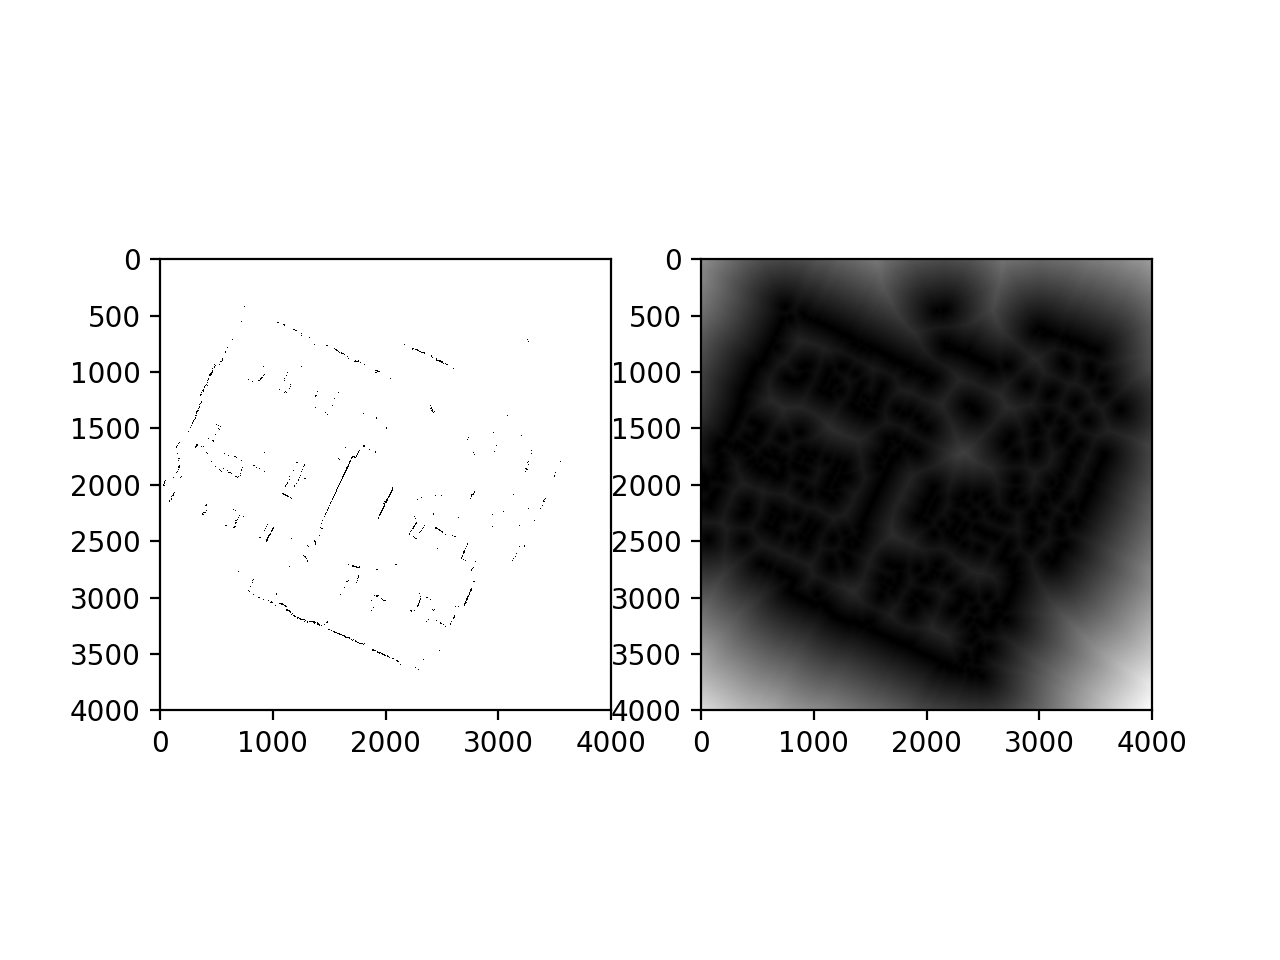

In [61]:
fig = plt.figure() #figsize=(20,20))
a = fig.add_subplot(121)
plt.imshow(bin_plan, cmap='gray')
a = fig.add_subplot(122)
plt.imshow(camfer_plan, cmap='gray')



In [28]:
def world_to_map(*args):
    if len(args) == 2:
        x, y = args
    elif len(args) == 1:
        x, y = args[0]
    else:
         raise TypeError("invalid arguments")  
        
    return int(x/WORLD_TO_MAP_SCALE), int(y/WORLD_TO_MAP_SCALE)


def map_to_world(*args):
    if len(args) == 2:
        x, y = args
    elif len(args) == 1:
        x, y = args[0]
    else:
         raise TypeError("invalid arguments")      
    
    return x*WORLD_TO_MAP_SCALE, y*WORLD_TO_MAP_SCALE

In [99]:
# Just a sample scan from a lidar
scan = [0, 0, 0, 0, 5165.25, 0, 0, 5100.75, 0, 0, 0, 0, 0, 0, 3306.0, 0, 0, 
        3328.75, 0, 2947.75, 0, 0, 3329.75, 0, 3676.75, 0, 0, 2338.0, 0, 0, 
        1589.5, 0, 2002.75, 0, 0, 1450.5, 0, 1467.0, 0, 0, 1487.0, 0, 0, 1517.0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3156.75, 0, 4546.75, 0, 0, 2438.0, 0, 
        4365.5, 0, 0, 1363.5, 0, 0, 1348.25, 0, 1336.25, 0, 0, 1320.0, 0, 1309.5, 
        0, 0, 1300.0, 0, 0, 1295.5, 0, 1288.0, 0, 0, 1323.25, 0, 0, 0, 1500.0, 0, 
        0, 1507.75, 0, 0, 1404.0, 0, 1336.75, 0, 0, 1309.0, 0, 1295.75, 0, 0, 1305.0,
        0, 1327.75, 0, 0, 0, 0, 0, 0, 4400.25, 0, 0, 4475.0, 0, 4500.0, 0, 0, 4592.5,
        0, 0, 0, 0, 6780.25, 0, 0, 0, 0, 0, 0, 0, 2736.25, 0, 0, 0, 0, 0, 0, 3287.0, 0, 
        5774.0, 0, 0, 5764.75, 0, 3357.75, 0, 0, 3671.75, 0, 0, 1764.25, 0, 2046.75, 0, 
        0, 1725.0, 0, 1698.5, 0, 0, 1670.75, 0, 0, 1648.5, 0, 1714.5, 0, 0, 1874.75, 0, 
        1984.0, 0, 0, 1737.0, 0, 0, 0, 0, 1965.0, 0, 1858.25, 0, 0, 0, 0, 0, 0, 0, 1801.0, 
        0, 1782.75, 0, 0, 1752.75, 0, 1764.25, 0, 0, 1661.0, 0, 1829.5, 0, 0, 1803.0, 0, 
        1828.0, 0, 0, 2326.0, 0, 2376.75, 0, 0, 2426.0, 0, 2478.0, 0, 0, 2524.75, 0, 2586.75, 
        0, 0, 2662.25, 0, 2733.0, 0, 0, 2823.5, 0, 2922.0, 0, 0, 3046.75, 0, 3163.25, 0, 0,
        3300.0, 0, 3459.5, 0, 0, 3656.25, 0, 3856.75, 0, 0, 3187.5, 0, 0, 0, 0, 1830.25, 0, 
        0, 1867.0, 0, 1690.5, 0, 0, 1649.0, 0, 0, 1281.0, 0, 1276.25, 0, 0, 1266.0, 0, 1262.25, 
        0, 0, 1257.25, 0, 1255.75, 0, 0, 1261.0, 0, 0, 1254.5, 0, 0, 0, 0, 0, 6661.25, 0, 0, 
        6720.25, 0, 6741.5, 0, 0, 5262.5, 0, 0, 0, 0, 0, 0, 0, 1435.25, 0, 0, 0, 0, 2176.75, 
        0, 2447.25, 0, 0, 0, 0, 2544.25, 0, 0, 2089.25, 0, 0, 2207.0, 0, 1732.0, 0, 0, 1870.0, 
        0, 1974.25, 0, 0, 2038.75, 0, 2101.5, 0, 0, 2171.5, 0, 3518.5, 0, 3310.25, 0, 0, 0, 0, 
        5074.0, 0, 0, 0, 0, 0, 0, 0, 2976.25, 0, 0, 4058.25, 0, 4002.5, 0, 0, 0, 0, 0, 0, 0, 0, 
        0, 5021.5, 0, 0, 5012.0, 0, 4944.25, 0, 0, 5123.0, 0, 5118.0, 0, 0, 0, 5125.5, 0, 5096.0, 
        0, 0, 5118.0, 0, 5133.0, 0, 0, 5167.75]


def polar_to_cartesian(scan):
    samples_no = len(scan)
    deg_per_sample = 360/samples_no
    
    def p2c(a, d):
        a = np.deg2rad(a)
        return d*math.cos(a), d*math.sin(a)
    
    ep = ((a*deg_per_sample, d) for a, d in enumerate(scan) if d != 0)
    ep = [p2c(a, d) for a, d in ep]

    return np.array(ep)
        

def transform_scan(scan, X):
    if not isinstance(scan, np.ndarray):
        scan = np.array(scan)
    
    ones = np.ones((len(scan), 1))
    scan = np.hstack((scan, ones))  # Homogenise coordinates
    
    
    x, y, t = X
    t = np.deg2rad(t)
    ct = math.cos(t)
    st = math.sin(t)

    m = np.matrix([
        [ct, -st, 0],
        [st,  ct, 0],
        [x,    y, 1]
    ])

    return np.asarray((np.asmatrix(scan)*m)[..., 0:2])


def scan_to_map_coords(scan):
    return np.apply_along_axis(world_to_map, 1, scan)


def cost_fn(distmap, pts):
    w, h = distmap.shape
    vs = np.fromiter((distmap[y, x]**2 for x, y in pts
          if (0 <= x < w) and (0 <= y < w)), dtype=np.float)
    return  np.average(vs) #  sum(vs)/len(vs)


def target_fn(X, scan, distance_map):
    scan = transform_scan(scan, X)
    map_pixels = scan_to_map_coords(scan)
    return cost_fn(distance_map, map_pixels)


target_fn((0,0,0), polar_to_cartesian(scan), camfer_plan)

246093.5728914757

[2590.030684 9761.133943 -35.902160]
[2584.707050 9751.857830 -36.067777]
[6510.697371 7838.919394 144.571573]
[2597.016529 9750.489285 -36.159883]
[2591.073263 9756.733256 -36.099642]
[6508.387528 7843.044045 144.629434]
[6516.928365 7848.561566 144.521343]
[2589.429439 9747.894691 -36.040972]
[2588.870369 9750.292174 -36.308700]
[9178.330739 12355.685355 -39.714574]
Estimated pose: [9178.330738696946, 12355.685355136187, -39.71457433018867]


<IPython.core.display.Javascript object>


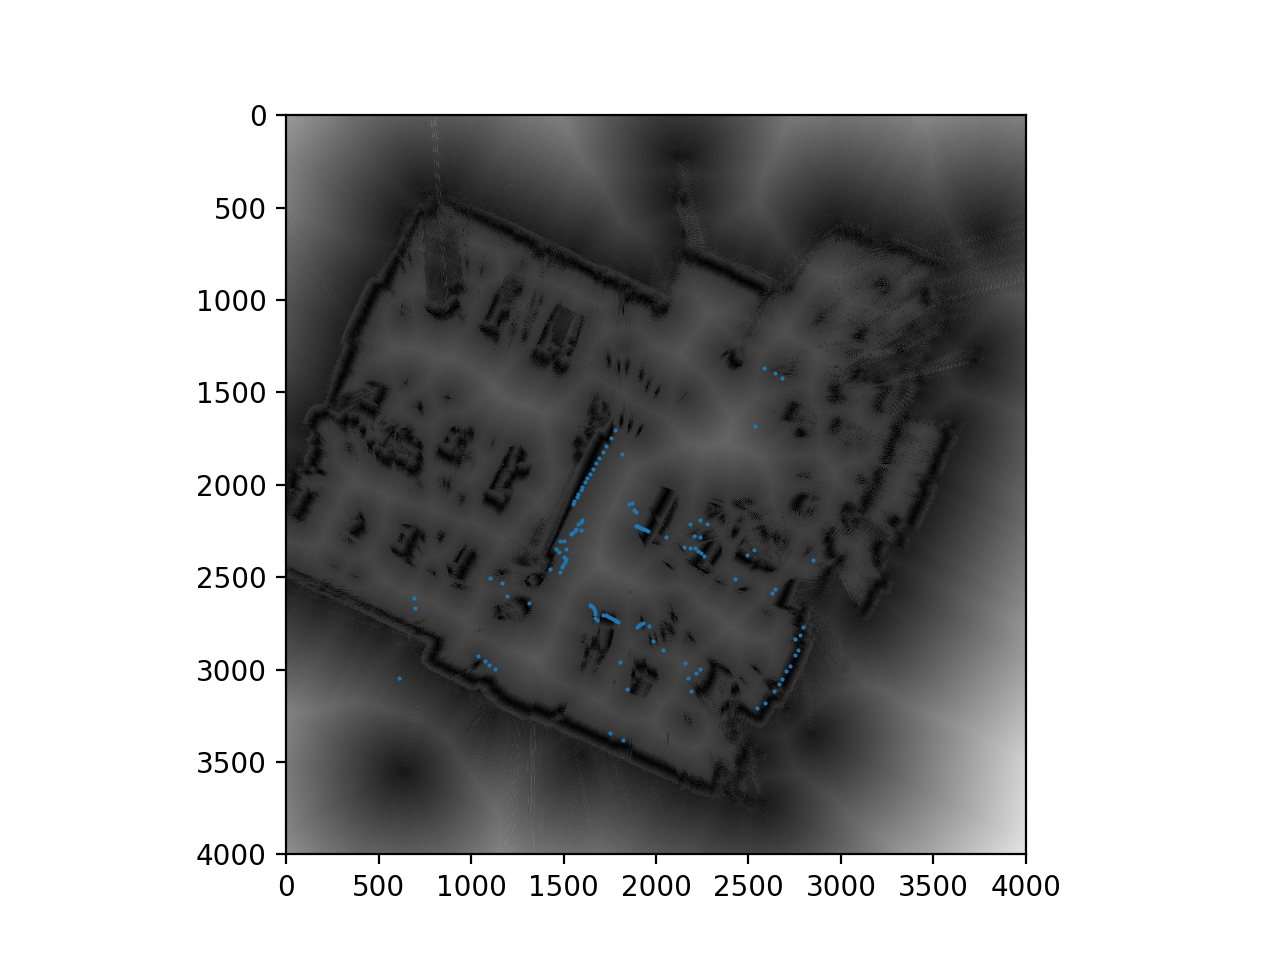

In [111]:
np.set_printoptions(formatter={'float_kind': (lambda v: '%.6f'%v)})


c_scan = polar_to_cartesian(scan)

minimization_space = camfer_plan

border = 500
bounds = ((border, MAP_SIZE_METERS*1000-border), 
          (border, MAP_SIZE_METERS*1000-border),
          (-180, 180))

for _ in range(10):
    opt_res = opt.differential_evolution(target_fn, bounds, args=(c_scan, minimization_space)
                                         )
    print(opt_res.x)

#opt_res = opt.minimize(target_fn, (MAP_SIZE_METERS*500, MAP_SIZE_METERS*500, 0),
#                       method='Powell', args=(c_scan, minimization_space),
#                      options={'disp': True})
#opt_res = opt.fmin_cg(target_fn, (MAP_SIZE_METERS*500, MAP_SIZE_METERS*500, 0), 
#                      args=(c_scan, minimization_space))

pose = list(opt_res.x)
print(f"Estimated pose: {pose}")
tr_scan = transform_scan(c_scan, pose)
scan_in_map = scan_to_map_coords(tr_scan)

fig = plt.figure()
plt.imshow(minimization_space, cmap='gray')
plt.imshow(floor_plan, cmap='gray', alpha=0.2)
plt.scatter(scan_in_map[:, 0], scan_in_map[:, 1], marker='.', s=1)
plt.show()

In [14]:
from itertools import chain
from multiprocessing import Pool

STEP = 100
BORDER = 1000
xys = ((x,y,t) for x in range(BORDER, MAP_SIZE_METERS*1000-BORDER, STEP)
             for y in range(BORDER, MAP_SIZE_METERS*1000-BORDER, STEP)
             for t in range(-180, 180, 5))

t = 0
def row_fn(p):
    return (p[0], p[1], p[2], target_fn(p))

with Pool(4) as p:
    values = p.map(row_fn , xys) # [(_x, _y, target_fn((_x, _y, _t))) for (_x, _y, _t) in xys]
    costs = np.fromiter(chain.from_iterable(values), dtype=np.float).reshape((-1, 4))
print(costs.shape)


(2332800, 4)
